# Machine Learning for Complete Intersection Calabi-Yau 3-folds

## Abstract

We consider the case of Complete Intersection Calabi-Yau manifolds of complex dimension 3 in the context of String Theory compactifications. We apply Machine Learning (ML) techniques to predict the values of the Hodge numbers $h_{1,1}$ and $h_{2,1}$ given their configuration matrix. We will however perform an extended Exploratory Data Analysis (EDA) before operating statistical inference on the data in order to get, clean and process data.

# Setup

In this section we start to load usable modules and define the operating characteristics of the machine before tackling more complex tasks.

In [1]:
# reload modules when running the notebook
%load_ext autoreload
%autoreload 2

## Specifications

The current analysis is performed on a machine with the following specifications:

In [2]:
!echo "CPU: $(head /proc/cpuinfo | awk -F': ' '/^model name/ {print $2}')"
!echo "GPU: $(lspci | awk -F': ' '/3D controller/ {print $2}')"
!echo "RAM: $(free --giga| awk '/^Mem/ {print $7}')GB available"

CPU: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz
GPU: NVIDIA Corporation GM108M [GeForce 940MX] (rev a2)
RAM: 10GB available


We then set the number of usable cores for parallel computations:

In [3]:
from os import cpu_count

# set no. of threads
THREADS = 8
MAX_THREADS = cpu_count()

# sanity check: cannot use more than available
if THREADS > MAX_THREADS:
    THREADS = MAX_THREADS

# print summary
print('Using {:d} of {:d} threads available.'.format(THREADS, MAX_THREADS))

Using 8 of 8 threads available.


We then create an operative directory structure to store, save and access files, figures and data:

In [4]:
from os import path, makedirs

# define directory names
ROOT_DIR = '.'
IMG_DIR  = 'img'
MOD_DIR  = 'mod'
LOG_DIR  = 'log'
DAT_DIR  = 'dat'
OUT_DIR  = 'out'

# get the name of the dataset
DB_NAME = 'cicy3o'
DB_FILE = DB_NAME + '.h5'
DB_PATH = path.join(ROOT_DIR, DB_FILE)

# define full paths
IMG_PATH = path.join(ROOT_DIR, IMG_DIR)
print('Images: {}'.format(IMG_PATH))
MOD_PATH = path.join(ROOT_DIR, MOD_DIR)
print('Models: {}'.format(MOD_PATH))
LOG_PATH = path.join(ROOT_DIR, LOG_DIR)
print('Logs:   {}'.format(LOG_PATH))
DAT_PATH = path.join(ROOT_DIR, DAT_DIR)
print('Data:   {}'.format(DAT_PATH))
OUT_PATH = path.join(ROOT_DIR, OUT_DIR)
print('Other:  {}'.format(OUT_PATH))

# define shortcuts for path of images, models, logs, data, etc.
imgpath = lambda s: path.join(IMG_PATH, s)
modpath = lambda s: path.join(MOD_PATH, s)
logpath = lambda s: path.join(LOG_PATH, s)
datpath = lambda s: path.join(DAT_PATH, s)
outpath = lambda s: path.join(OUT_PATH, s)

# create directories if non existent
if not path.isdir(IMG_PATH):
    makedirs(IMG_PATH, exist_ok = True)
if not path.isdir(MOD_PATH):
    makedirs(MOD_PATH, exist_ok = True)
if not path.isdir(LOG_PATH):
    makedirs(LOG_PATH, exist_ok = True)
if not path.isdir(DAT_PATH):
    makedirs(DAT_PATH, exist_ok = True)
if not path.isdir(OUT_PATH):
    makedirs(OUT_PATH, exist_ok = True)

Images: ./img
Models: ./mod
Logs:   ./log
Data:   ./dat
Other:  ./out


Important information will be saved in a log, stored in its directory:

In [5]:
import logging

from os   import path, rename
from time import strftime, gmtime

# call the log with the same name as the dataset we use
logname  = DB_NAME 
filename = path.join(LOG_PATH, DB_NAME + '.log')
ctime    = strftime('_%Y%m%d.%H%M%S', gmtime())
level    = logging.DEBUG

# rotate the log if one is already present
if path.isfile(filename):
    rename(filename, filename + ctime)

# print the log to file
log = logging.getLogger(logname + ctime)
fmt = logging.Formatter('%(asctime)s: %(levelname)s ==> %(message)s')
han = logging.FileHandler(filename = filename)
log.setLevel(level)
han.setLevel(level)
han.setFormatter(fmt)
log.addHandler(han)

# write introduction to log
log.info('\n\n'
         '----------------------------------------------\n'
         '  MACHINE LEARNING FOR CICY 3-FOLDS\n\n'
         '----------------------------------------------\n'
         '  Authors: Harold Erbin, Riccardo Finotello\n'
         '----------------------------------------------\n'
         '  Abstract:\n\n'
         '  In the context of String Theory\n'
         '  compactifications, we consider CICY 3-folds\n'
         '  and use machine learning to predict the\n'
         '  values of the Hodge numbers h_11 and h_21.\n\n'
        )

print('Current log: {}'.format(filename))

Current log: ./log/cicy3o.log


We finally import the modules we use in the analysis and check their versions:

In [6]:
# check Python version
import sys
assert sys.version_info.major > 2 and sys.version_info.minor > 5
print('Python version: {}.{}.{}'.format(sys.version_info.major,
                                        sys.version_info.minor,
                                        sys.version_info.micro
                                       )
     )

# import Numpy
import numpy as np
assert np.__version__ >= '1.18'
print('Numpy version:           {}'.format(np.__version__))

# import Pandas
import pandas as pd
assert pd.__version__  >= '1.0'
print('Pandas version:          {}'.format(pd.__version__))

# import Seaborn and Matplotlib
import seaborn           as sns
import matplotlib        as mpl
import matplotlib.pyplot as plt
assert mpl.__version__ >= '3.1' and sns.__version__ >= '0.10'
print('Matplotlib version:      {}'.format(mpl.__version__))
print('Seaborn version:         {}'.format(sns.__version__))
%matplotlib inline

sns.set()
subplots = lambda x, y: plt.subplots(x, y, figsize=(y*6, x*5))

# import Scikit-learn and Scikit-optimize
import sklearn
import skopt
assert sklearn.__version__ >= '0.22' and skopt.__version__ >= '0.7'
print('Scikit-learn version:    {}'.format(sklearn.__version__))
print('Scikit-optimize version: {}'.format(skopt.__version__))

# import LightGBM and check for the newest version
import lightgbm
assert lightgbm.__version__ >='2.0'
print('LightGBM version:        {}'.format(lightgbm.__version__))

# import Tensorflow (check that Keras is included: v2.0+)
import tensorflow as tf
assert tf.__version__ > '2.0'
print('Tensorflow version:      {}'.format(tf.__version__))

# check the SHAP version
import shap
assert shap.__version__ >= '0.35'
print('SHAP version:            {}'.format(shap.__version__))

# check the warnings (I can't really handle UserWarnings unfortunately...)
import warnings
warnings.simplefilter('ignore', category = UserWarning)

# set the random state for reproducibility
RAND = 121
np.random.seed(RAND)
np.random.RandomState(RAND)
tf.random.set_seed(RAND)

Python version: 3.8.3
Numpy version:           1.18.5
Pandas version:          1.0.5
Matplotlib version:      3.2.2
Seaborn version:         0.10.1
Scikit-learn version:    0.22.1
Scikit-optimize version: 0.7.4
LightGBM version:        2.3.1
Tensorflow version:      2.2.0
SHAP version:            0.35.0


For some computations we will be using GPU acceleration: we fix the amount of memory accessible by the GPU in order to limit its growth and to allocate only the necessary amount at runtime.

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU') # physical GPUs
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
log.debug('Set GPU memory growth.')

# Getting and Cleaning the Data

We then download the dataset and clean it to have more accessible variables during the analysis.

In [8]:
import tarfile
from urllib import request

# compose the URL
URL_ROOT = 'http://www.lpthe.jussieu.fr/~erbin/files/data/'
TAR_FILE = DB_NAME + '_data.tar.gz'
TAR_PATH = path.join(ROOT_DIR, TAR_FILE)

# download the file
if not path.isfile(TAR_PATH):
    request.urlretrieve(URL_ROOT + TAR_FILE, TAR_PATH)
    
# open the tarball
if path.isfile(TAR_PATH):
    with tarfile.open(TAR_PATH, 'r') as tar:
        tar.extract(DB_FILE, ROOT_DIR)
        
if path.isfile(DB_FILE):
    log.debug('File successfully downloaded.')
else:
    log.error('Cannot download dataset!')

We can now read the database and check its composition:

In [9]:
df = pd.read_hdf(DB_FILE)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7890 entries, 1 to 7890
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   c2              7890 non-null   object 
 1   euler           7890 non-null   int16  
 2   h11             7890 non-null   int16  
 3   h21             7890 non-null   int16  
 4   matrix          7890 non-null   object 
 5   redun           7890 non-null   object 
 6   size            7890 non-null   object 
 7   num_cp          7890 non-null   int8   
 8   num_eqs         7890 non-null   int64  
 9   dim_cp          7890 non-null   object 
 10  min_dim_cp      7890 non-null   int64  
 11  max_dim_cp      7890 non-null   int64  
 12  mean_dim_cp     7890 non-null   float64
 13  median_dim_cp   7890 non-null   float64
 14  num_dim_cp      7890 non-null   object 
 15  num_cp_1        7890 non-null   int8   
 16  num_cp_2        7890 non-null   int8   
 17  num_cp_neq1     7890 non-null   i

The database contains multiple entries, some in a non numeric format (`object`, that is). It is made of:

In [10]:
print('No. of rows:    {:d}'.format(df.shape[0]))
print('No. of columns: {:d}'.format(df.shape[1]))

No. of rows:    7890
No. of columns: 31


We can take a look at a few of its entries to get an idea of its content:

In [11]:
df.head(3)

,c2,euler,h11,h21,matrix,redun,size,num_cp,num_eqs,dim_cp,...,min_deg_eqs,max_deg_eqs,mean_deg_eqs,median_deg_eqs,num_deg_eqs,rank_matrix,norm_matrix,dim_h0_amb,isprod,favour
1,"[24, 24, 24, 24, 24, 36, 36]",0,15,15,"[[1, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 1], [0, 0...",[],"[7, 6]",7,6,"[1, 1, 1, 1, 1, 2, 2]",...,2,3,2.666667,3.0,"[0, 2, 4, 0, 0, 0, 0, 0]",6,4.472136,"[8, 6, 6, 12, 12, 8]",0,0
2,"[24, 24, 24, 24, 24, 36, 36]",0,15,15,"[[1, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 1], [0, 0...",[],"[7, 6]",7,6,"[1, 1, 1, 1, 1, 2, 2]",...,2,3,2.666667,3.0,"[0, 2, 4, 0, 0, 0, 0, 0]",6,4.472136,"[8, 6, 8, 12, 12, 6]",0,0
3,"[24, 24, 24, 36, 36, 36]",0,15,15,"[[1, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 1], [0, 0...",[],"[6, 6]",6,6,"[1, 1, 1, 2, 2, 2]",...,2,3,2.500000,2.5,"[0, 3, 3, 0, 0, 0, 0, 0]",6,4.582576,"[12, 6, 6, 6, 12, 12]",0,0


As we can see the database need to be tidied since there are columns holding multiple observations. We will try to expand over columns the vector quantities to be more accessible. However we will also save the shape of each of the original columns to have use later.

First of all, however, we need to extract vector and matrices from their sparse format into a dense format:

In [12]:
def extract_series(series: pd.Series) -> pd.Series:
    '''
    Extract a Pandas series into its dense format.
    
    Required arguments:
        series: the pandas series.
        
    Returns:
        the pandas series in dense format.
    '''
    # avoid direct overwriting
    series = series.copy()
    
    # cget the maximum size of each axis
    max_shape = series.apply(np.shape).max()
    
    # return the transformed series
    if np.prod(max_shape) > 1:
        # compute the necessary shift and apply it
        offset = lambda s: [(0, max_shape[i] - np.shape(s)[i])
                            for i in range(len(max_shape))
                           ]
        return series.apply(lambda s: np.pad(s, offset(s), mode='constant'))
    else:
        return series
    
# applyit to all variables of the dataset 
df = df.apply(extract_series)

We then save the shape of each variable to be accessible later:

In [13]:
shape_dict = df.applymap(np.shape).\
                apply(np.unique).\
                to_dict(orient='records')[0]

We now flatten each vector and expand it over the rows to have only one observation for each variable. We also take this change to reorder the dataframe to have the prediction labels to the left and be able to join the variables to the right:

In [14]:
def explode_variables(series: pd.Series) -> pd.DataFrame:
    '''
    Take one variable and explode its components in a new column.
    
    Required arguments:
        series: the variable to explode.
        
    Returns:
        a dataframe containing one observable for each column.
    '''
    # avoid direct overwriting
    series = series.copy()
    
    if series.apply(lambda x: np.prod(np.shape(x))).max() == 1:
        return series
    else:
        # flatten the array
        series = series.apply(lambda x: np.reshape(x, (-1,)))

        # explode over columns
        series = series.apply(pd.Series).\
                        rename(columns=lambda x: \
                                       series.name + '_{}'.format(x+1))

        return series
    
# decide the new order of the columns
column_list = ['h11', 'h21', 'euler',
               'c2', 'redun', 'size', 'isprod', 'favour',
               'num_cp', 'num_eqs',
               'dim_h0_amb',
               'dim_cp', 'num_dim_cp',
               'min_dim_cp', 'max_dim_cp', 'mean_dim_cp', 'median_dim_cp',
               'num_cp_1', 'num_cp_2', 'num_cp_neq1',
               'num_over', 'num_ex',
               'deg_eqs', 'num_deg_eqs',
               'min_deg_eqs', 'max_deg_eqs', 'mean_deg_eqs', 'median_deg_eqs',
               'rank_matrix', 'norm_matrix',
               'matrix' 
              ]

# create a new data frame and "left join" each exploded variable
df_new = pd.DataFrame(index=df.index)
for f in column_list:
    df_new = df_new.join(explode_variables(df[f]))
    
# overwrite old file
df = df_new.copy()
del df_new

We then check if there are any duplicated rows in the dataset (i.e. columns which have identical values all over):

In [15]:
df.duplicated().rename('duplicates').agg({'sum', 'mean'})

sum     0.0
mean    0.0
Name: duplicates, dtype: float64

Since there are none, we do not need to delete any. We finally save the resulting dataset to file.

In [16]:
df.to_csv(datpath(DB_NAME + '_tidy.csv'), index=False)
log.debug('Tidy database has been saved to file.')

# Exploratory Data Analysis

In this section we present the EDA on the tidy dataset. We intend to study and present properties and visualisation of the data we are going to study.

We start from studying the distribution of the prediction labels:

In [17]:
labels_full = df[['h11', 'h21']]
labels_full.describe()

,h11,h21
count,7890.000000,7890.000000
mean,7.419772,28.744740
std,2.250891,8.577282
min,0.000000,0.000000
25%,6.000000,23.000000
50%,7.000000,27.000000
75%,9.000000,33.000000
max,19.000000,101.000000


In particular we see that they involve two different scales of values ($h_{1,1}$ is order $10$ while $h_{2,1}$ is order $100$). We plot the histogram of their distribution:

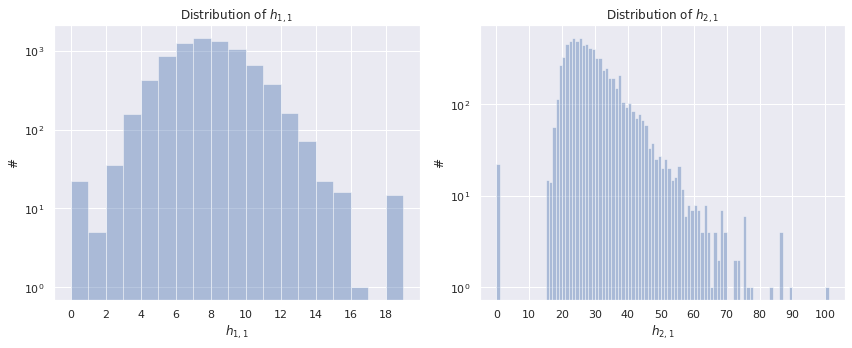

In [18]:
fig, ax = subplots(1,2)

sns.distplot(labels_full['h11'],
             bins=np.arange(min(labels_full['h11']),
                            max(labels_full['h11'])+1
                           ),
             kde=False,
             ax=ax[0]
            )
ax[0].set(title='Distribution of $h_{1,1}$',
          xlabel='$h_{1,1}$',
          ylabel='#',
          yscale='log',
          xticks=np.arange(min(labels_full['h11']),
                           max(labels_full['h11']),
                           2
                          )
         )

sns.distplot(labels_full['h21'],
             bins=np.arange(min(labels_full['h21']),
                            max(labels_full['h21'])+1
                           ),
             kde=False,
             ax=ax[1]
            )
ax[1].set(title='Distribution of $h_{2,1}$',
          xlabel='$h_{2,1}$',
          ylabel='#',
          yscale='log',
          xticks=np.arange(min(labels_full['h21']),
                           max(labels_full['h21']),
                           10
                          )
         )

plt.tight_layout()
plt.savefig(imgpath('label-distribution_orig.pdf'), dpi=150, format='pdf')

In this analysis we will however be interested in a particular subset of the distributions: we consider only matrices which are not products of other subspaces (i.e. we choose to keep `isprod` $= 0$) and remove large outliers of the distribution.

In [19]:
# remove product spaces and large outliers
df_clean = df.loc[(df['isprod'] == 0) &
                  ((df['h11'] >= 1) & (df['h11'] <= 16)) &
                  ((df['h21'] >= 1) & (df['h21'] <= 86))
                 ].reset_index(drop=True)
labels_clean = df_clean[['h11', 'h21']]

The new distribution of $h_{1,1}$ and $h_{2,1}$ can then be compared with what we had before:

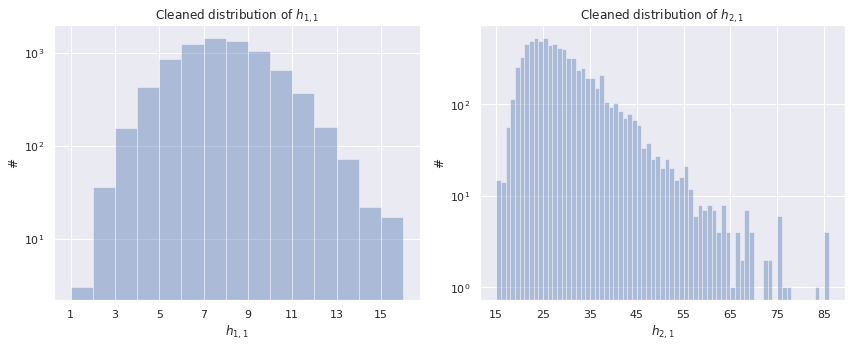

In [20]:
fig, ax = subplots(1,2)

sns.distplot(labels_clean['h11'],
             bins=np.arange(min(labels_clean['h11']),
                            max(labels_clean['h11']) + 1
                           ),
             kde=False,
             ax=ax[0]
            )
ax[0].set(title='Cleaned distribution of $h_{1,1}$',
          xlabel='$h_{1,1}$',
          ylabel='#',
          yscale='log',
          xticks=np.arange(min(labels_clean['h11']),
                           max(labels_clean['h11']),
                           2
                          )
         )

sns.distplot(labels_clean['h21'],
             bins=np.arange(min(labels_clean['h21']),
                            max(labels_clean['h21']) + 1
                           ),
             kde=False,
             ax=ax[1]
            )
ax[1].set(title='Cleaned distribution of $h_{2,1}$',
          xlabel='$h_{2,1}$',
          ylabel='#',
          yscale='log',
          xticks=np.arange(min(labels_clean['h21']),
                           max(labels_clean['h21']),
                           10
                          )
         )

plt.tight_layout()
plt.savefig(imgpath('label-distribution-clean_orig.pdf'), dpi=150, format='pdf')

As we can see the distribution is much cleaner in this case and can be used for training. We finally use a boxplot to better visualise the differences in the plots:

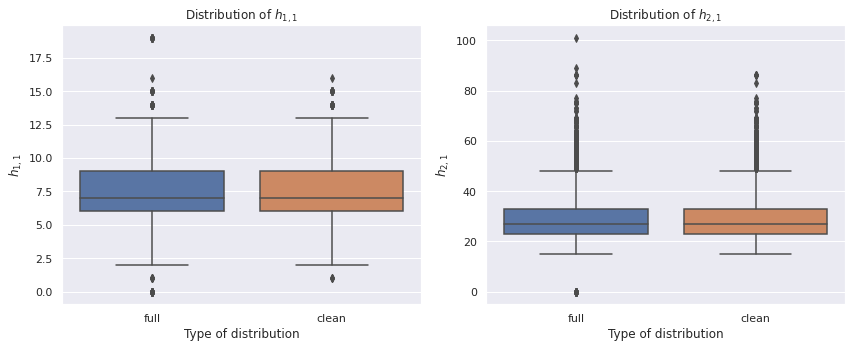

In [21]:
box_data = {'type':       ['full'] * labels_full.shape[0] +
                          ['clean'] * labels_clean.shape[0],
            'h11_values': np.hstack((labels_full['h11'].values,
                                     labels_clean['h11'].values
                                    )
                                   ),
            'h21_values': np.hstack((labels_full['h21'].values,
                                     labels_clean['h21'].values
                                    )
                                   )
           }

fig, ax = subplots(1,2)

sns.boxplot(data=pd.DataFrame(box_data),
            x='type',
            y='h11_values',
            ax=ax[0]
           )
ax[0].set(title='Distribution of $h_{1,1}$',
          xlabel='Type of distribution',
          ylabel='$h_{1,1}$'
         )

sns.boxplot(data=pd.DataFrame(box_data),
            x='type',
            y='h21_values',
            ax=ax[1]
           )
ax[1].set(title='Distribution of $h_{2,1}$',
          xlabel='Type of distribution',
          ylabel='$h_{2,1}$'
         )

plt.tight_layout()
plt.savefig(imgpath('label-distribution-compare_orig.pdf'),
            dpi=150,
            format='pdf'
           )

We then present the correlation matrix of the scalar values in the dataset. First we select the values necessary for the computation:

In [22]:
scalar_columns = [col for col in column_list if np.prod(shape_dict[col]) == 1
                                             and col != 'isprod'
                                             and col != 'favour'
                 ]

We then plot the values in a heatmap.

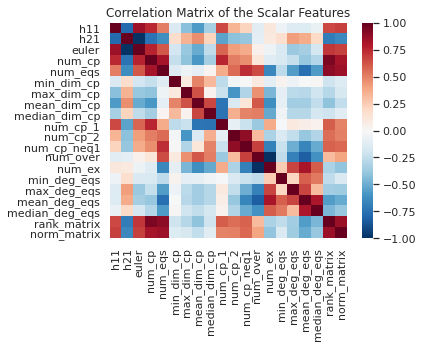

In [23]:
fig, ax = subplots(1,1)

sns.heatmap(df_clean[scalar_columns].corr(),
            vmin=-1.0,
            vmax=1.0,
            norm=mpl.colors.DivergingNorm(0.0),
            cmap='RdBu_r',
            ax=ax
           )
ax.set_title('Correlation Matrix of the Scalar Features')

plt.tight_layout()
plt.savefig(imgpath('corr-matrix_orig.pdf'), dpi=150, format='pdf')

As we can see the most engineered features are quickly highly correlated and may help in statistical inference of the labels.

We then show the distribution of the labels as a function of several scalar values: we choose the engineered features which show the highest correlation with the labels:

In [24]:
# define a function to extract the information
def get_unique(df: pd.DataFrame, feature: str, label: str) -> pd.DataFrame:
    '''
    Get the unique values and the no. of occurrencies.
    
    Required arguments:
        feature: the name of the feature,
        label:   the name of the label.
        
    Returns:
        a dataframe with the information.
    '''
    counts = df.groupby(feature)[label].value_counts()
    
    # store data in a dataframe
    data = {feature:      [c[0] for c in counts.index],
            label:        [c[1] for c in counts.index],
            'frequency':  counts.values
           }
    return pd.DataFrame(data)

We then plot the distributions of the labels with respect to correlated data:

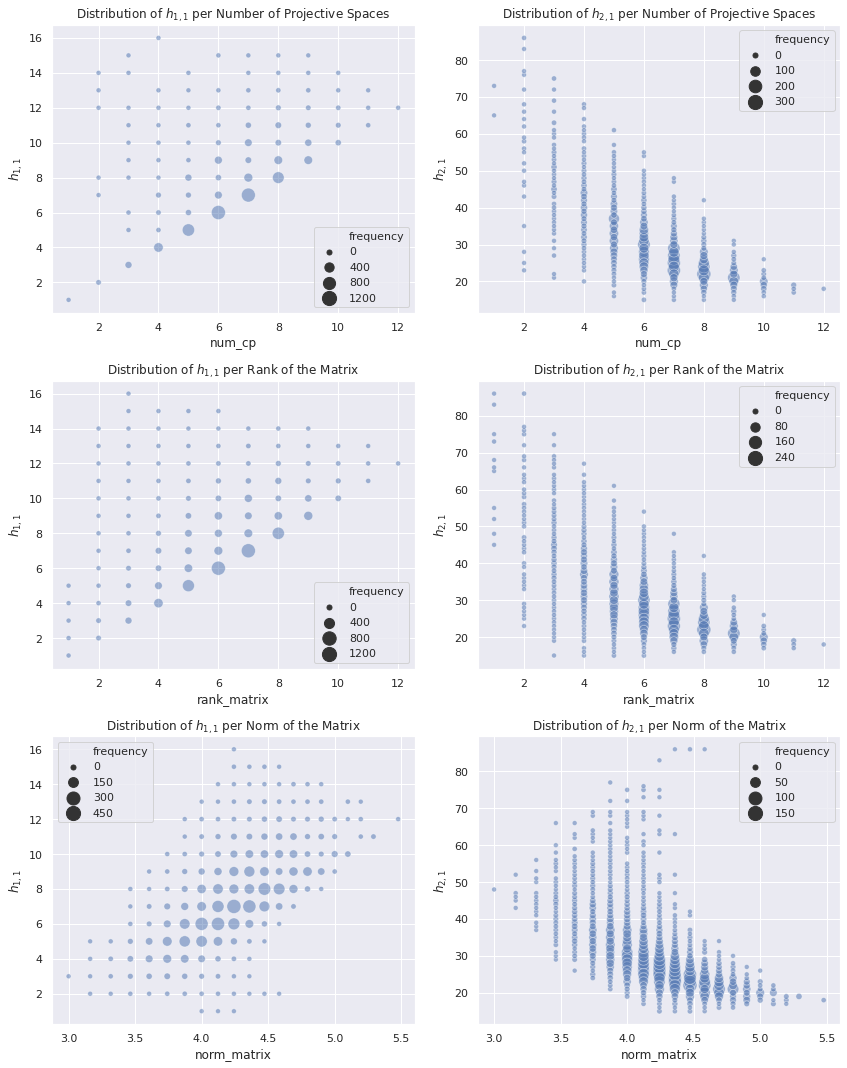

In [25]:
fig, ax = subplots(3,2)

sns.scatterplot(data=get_unique(df_clean, 'num_cp', 'h11'),
                x='num_cp',
                y='h11',
                size='frequency',
                sizes=(25,200),
                alpha=0.5,
                ax=ax[0,0]
               )
ax[0,0].set(title='Distribution of $h_{1,1}$ per Number of Projective Spaces',
            xlabel='num_cp',
            ylabel='$h_{1,1}$'
           )
sns.scatterplot(data=get_unique(df_clean, 'num_cp', 'h21'),
                x='num_cp',
                y='h21',
                size='frequency',
                sizes=(25,200),
                alpha=0.5,
                ax=ax[0,1]
               )
ax[0,1].set(title='Distribution of $h_{2,1}$ per Number of Projective Spaces',
            xlabel='num_cp',
            ylabel='$h_{2,1}$'
           )

sns.scatterplot(data=get_unique(df_clean, 'rank_matrix', 'h11'),
                x='rank_matrix',
                y='h11',
                size='frequency',
                sizes=(25,200),
                alpha=0.5,
                ax=ax[1,0]
               )
ax[1,0].set(title='Distribution of $h_{1,1}$ per Rank of the Matrix',
            xlabel='rank_matrix',
            ylabel='$h_{1,1}$'
           )
sns.scatterplot(data=get_unique(df_clean, 'rank_matrix', 'h21'),
                x='rank_matrix',
                y='h21',
                size='frequency',
                sizes=(25,200),
                alpha=0.5,
                ax=ax[1,1]
               )
ax[1,1].set(title='Distribution of $h_{2,1}$ per Rank of the Matrix',
            xlabel='rank_matrix',
            ylabel='$h_{2,1}$'
           )

sns.scatterplot(data=get_unique(df_clean, 'norm_matrix', 'h11'),
                x='norm_matrix',
                y='h11',
                size='frequency',
                sizes=(25,200),
                alpha=0.5,
                ax=ax[2,0]
               )
ax[2,0].set(title='Distribution of $h_{1,1}$ per Norm of the Matrix',
            xlabel='norm_matrix',
            ylabel='$h_{1,1}$'
           )
sns.scatterplot(data=get_unique(df_clean, 'norm_matrix', 'h21'),
                x='norm_matrix',
                y='h21',
                size='frequency',
                sizes=(25,200),
                alpha=0.5,
                ax=ax[2,1]
               )
ax[2,1].set(title='Distribution of $h_{2,1}$ per Norm of the Matrix',
            xlabel='norm_matrix',
            ylabel='$h_{2,1}$'
           )

plt.tight_layout()
plt.savefig(imgpath('distr-labels-corr-feat_orig.pdf'), dpi=150, format='pdf')

## PCA and K-Means Clustering

We then consider two more different approached to the dataset. Namely we study the Principal Components Analysis (PCA) and the clustering (using **K-means**) of the components of the matrix.

In [26]:
matrix_comp = df_clean.filter(regex='matrix_.*')

We start from the PCA of the matrix by first studying its Singular Value Decomposition (SVD), thus showing the amount of variance retained by each principal component. We first shift the matrix components to have a central distribution with 0 mean:

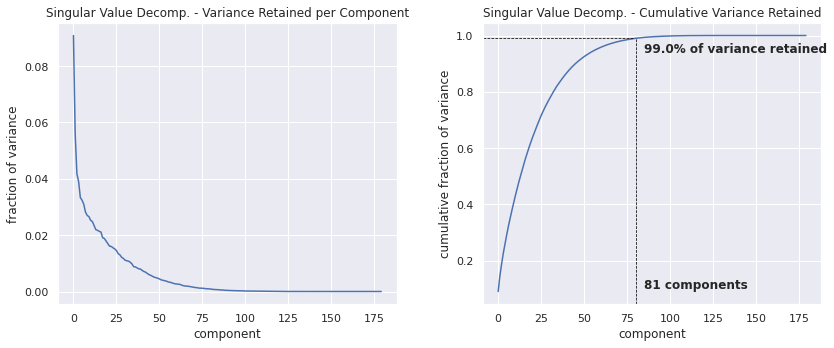

In [27]:
# center the distribution before proceeding
matrix_ctr = matrix_comp - matrix_comp.apply('mean')

# compute the SVD
log.info('Computing SVD.')
_, S, _ = np.linalg.svd(matrix_ctr)

# compute the variance (and its cumulative sum)
S2    = S ** 2 / np.sum(S ** 2)
S2cum = np.cumsum(S2)

# plot the retained variance by component
fig, ax = subplots(1,2)

sns.lineplot(x=np.arange(len(S2)),
             y=S2,
             ax=ax[0]
            )
ax[0].set(title='Singular Value Decomp. - Variance Retained per Component',
          xlabel='component',
          ylabel='fraction of variance'
         )

sns.lineplot(x=np.arange(len(S2cum)),
             y=S2cum,
             ax=ax[1]
            )
ax[1].set(title='Singular Value Decomp. - Cumulative Variance Retained',
          xlabel='component',
          ylabel='cumulative fraction of variance'
         )

# add lines where part of the total variance is retained
var_ret = 0.99
ax[1].axhline(var_ret,
              xmin=0,
              xmax=np.argmax(S2cum >= var_ret) / len(S2cum),
              linestyle='--',
              linewidth=0.75,
              c='black'
             )
ax[1].axvline(np.argmax(S2cum >= var_ret),
              ymin=0,
              ymax=var_ret / ax[1].get_ylim()[1],
              linestyle='--',
              linewidth=0.75, c='black'
             )
ax[1].text(np.argmax(S2cum >= var_ret) + 5, var_ret - 0.05,
           '{}% of variance retained'.format(var_ret * 100),
           fontweight='bold'
          )
ax[1].text(np.argmax(S2cum >= var_ret) + 5, 0.1,
           '{:d} components'.format(np.argmax(S2cum >= var_ret) + 1),
           fontweight='bold'
          )

plt.tight_layout()
plt.savefig(imgpath('svd_orig.pdf'), dpi=150, format='pdf')

We can then directly compute the projection on the principal components retaining 99% of the variance inside the data (we will also compute the same object with up to 3 components for visualisation purposes):

In [28]:
from sklearn.decomposition import PCA

# compute the "good" PCA
log.info('Computing PCA.')
matrix_comp_pca = PCA(n_components=0.99).fit_transform(matrix_comp)
matrix_comp_pca = pd.DataFrame(matrix_comp_pca).\
                     rename(columns=lambda x: 'pca_' + str(x+1))

# add the PCA to the dataset
df = df_clean.join(matrix_comp_pca)

# compute the "simple" PCA
matrix_comp_vis2 = PCA(n_components=2).fit_transform(matrix_comp)
matrix_comp_vis2 = pd.DataFrame(matrix_comp_vis2).\
                      rename(columns=lambda x: 'pca_' + str(x+1))
matrix_comp_vis3 = PCA(n_components=3).fit_transform(matrix_comp)
matrix_comp_vis3 = pd.DataFrame(matrix_comp_vis3).\
                      rename(columns=lambda x: 'pca_' + str(x+1))

The visualisation can be performed by plotting the values of the PCA on a scatter plot:

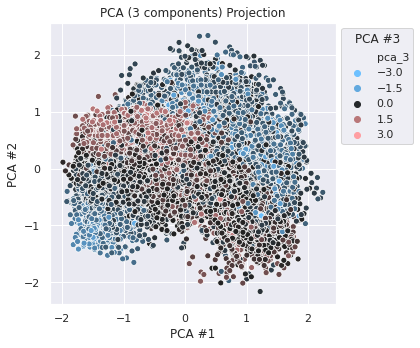

In [29]:
fig, ax = subplots(1,1)

sns.scatterplot(data=matrix_comp_vis3,
                x='pca_1',
                y='pca_2',
                hue='pca_3',
                palette=sns.diverging_palette(240, 10,
                                              s=100,
                                              l=75,
                                              center='dark',
                                              as_cmap=True
                                             ),
                ax=ax
               )
ax.set(title='PCA (3 components) Projection',
       xlabel='PCA #1',
       ylabel='PCA #2'
      )
ax.legend(title='PCA #3',
          loc='upper left',
          bbox_to_anchor=(1.0, 1.0)
         )

plt.tight_layout()
plt.savefig(imgpath('pca-3_orig.pdf'), dpi=150, format='pdf')

We then consider the clustering algorithm:

In [30]:
from sklearn.cluster import KMeans

# compute the labels of the clusters
kmeans = lambda n: KMeans(n_clusters=n,
                          random_state=RAND).fit_predict(matrix_comp)

# add labels to the dataset
cluster_range = range(2,16)
for n in cluster_range:
    log.info('Computing KMeans with {:d} clusters'.format(n))
    df['kmeans_' + str(n)] = kmeans(n)

We can visualise the clusterisation of the matrix by plotting the labels we predict using the clusters as colour map (we chose to plot for instance the case of 2 and 15 clusters):

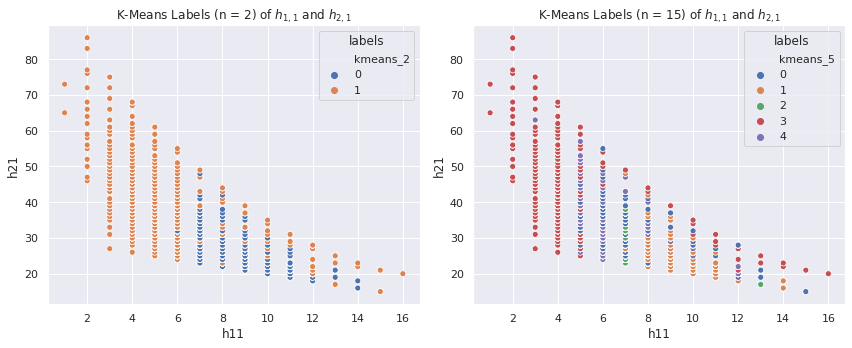

In [31]:
fig, ax = subplots(1,2)

sns.scatterplot(data=df,
                x='h11',
                y='h21',
                hue='kmeans_2',
                ax=ax[0]
               )
ax[0].set(title='K-Means Labels (n = 2) of $h_{1,1}$ and $h_{2,1}$')
ax[0].legend(title='labels')

sns.scatterplot(data=df,
                x='h11',
                y='h21',
                hue='kmeans_5',
                palette=sns.color_palette(n_colors=5),
                ax=ax[1]
               )
ax[1].set(title='K-Means Labels (n = 15) of $h_{1,1}$ and $h_{2,1}$')
ax[1].legend(title='labels')

plt.tight_layout()
plt.savefig(imgpath('clusters_orig.pdf'), dpi=150, format='pdf')

Ultimately we save the dataset to file for further use:

In [32]:
df.to_csv(datpath(DB_NAME + '_full.csv'), index=False)
log.info('Full database has been saved to file.')

# Feature Importance and Selection

We then consider the variable ranking obtained by fitting a random forest algorithm to the data we find. We will be interested in keeping only the most important features.

For this part of the analysis, we drop the labels from the dataset and we divide it into two separate dataframes, one containing engineered features and the matrix, and the other containing the PCA instead of the matrix to avoid duplication:

In [33]:
# drop labels and non topological features
drop_columns = list(\
    df.filter(regex='h11|h21|euler|^c2.*|^is.*|^fav.*|^size.*|^redun.*'))

# separate pca and matrix columns
pca_columns  = list(df.filter(regex='^pca.*'))
mat_columns  = list(df.filter(regex='^matr.*'))

pca_feat = df.drop(columns=drop_columns).drop(columns=mat_columns)
mat_feat = df.drop(columns=drop_columns).drop(columns=pca_columns)

# take the labels
h11 = df['h11'].values.reshape(-1,)
h21 = df['h21'].values.reshape(-1,)

Variable ranking is achieved by training a decision tree on the data. We use a random forest as an ensemble technique for using decision trees and bootstrap after standardisation of the samples:

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble      import RandomForestRegressor
from sklearn.pipeline      import Pipeline

# define the pipeline
pip_list = [('standardisation', StandardScaler()),
            ('variableranking', RandomForestRegressor(n_estimators=100,
                                                      n_jobs=THREADS,
                                                      random_state=RAND
                                                     )
            )
           ]

# fit the training data and recover the importance of the features
log.info('Fitting random forest for variable ranking.')
rf_mat_h11 = Pipeline(pip_list, verbose=True).fit(mat_feat, h11).\
             named_steps['variableranking'].feature_importances_
rf_pca_h11 = Pipeline(pip_list, verbose=True).fit(pca_feat, h11).\
             named_steps['variableranking'].feature_importances_
rf_mat_h21 = Pipeline(pip_list, verbose=True).fit(mat_feat, h21).\
             named_steps['variableranking'].feature_importances_
rf_pca_h21 = Pipeline(pip_list, verbose=True).fit(pca_feat, h21).\
             named_steps['variableranking'].feature_importances_

[Pipeline] ... (step 1 of 2) Processing standardisation, total=   0.1s
[Pipeline] ... (step 2 of 2) Processing variableranking, total=   6.8s
[Pipeline] ... (step 1 of 2) Processing standardisation, total=   0.1s
[Pipeline] ... (step 2 of 2) Processing variableranking, total=  28.8s
[Pipeline] ... (step 1 of 2) Processing standardisation, total=   0.0s
[Pipeline] ... (step 2 of 2) Processing variableranking, total=   4.0s
[Pipeline] ... (step 1 of 2) Processing standardisation, total=   0.0s
[Pipeline] ... (step 2 of 2) Processing variableranking, total=  27.9s


We can then collect the variable importances from the previous pipelines:

In [35]:
import re

# get the labels
mat_labels = list(mat_feat.columns)
pca_labels = list(pca_feat.columns)

# stem each label in the list:
mat_labels_stem = [re.sub('^matrix_.*', 'matrix', s)
                   for s in mat_labels]
mat_labels_stem = [re.sub('^dim_h0_amb_.*', 'dim_h0_amb', s)
                   for s in mat_labels_stem]
mat_labels_stem = [re.sub('^dim_cp_.*', 'dim_cp', s)
                   for s in mat_labels_stem]
mat_labels_stem = [re.sub('^num_dim_cp_.*', 'num_dim_cp', s)
                   for s in mat_labels_stem]
mat_labels_stem = [re.sub('^deg_eqs_.*', 'deg_eqs', s)
                   for s in mat_labels_stem]
mat_labels_stem = [re.sub('^num_deg_eqs_.*', 'num_deg_eqs', s)
                   for s in mat_labels_stem]
mat_labels_stem = [re.sub('^kmeans_.*', 'kmeans', s)
                   for s in mat_labels_stem]

pca_labels_stem = [re.sub('^pca_.*', 'pca', s)
                   for s in pca_labels]
pca_labels_stem = [re.sub('^dim_h0_amb_.*', 'dim_h0_amb', s)
                   for s in pca_labels_stem]
pca_labels_stem = [re.sub('^dim_cp_.*', 'dim_cp', s)
                   for s in pca_labels_stem]
pca_labels_stem = [re.sub('^num_dim_cp_.*', 'num_dim_cp', s)
                   for s in pca_labels_stem]
pca_labels_stem = [re.sub('^deg_eqs_.*', 'deg_eqs', s)
                   for s in pca_labels_stem]
pca_labels_stem = [re.sub('^num_deg_eqs_.*', 'num_deg_eqs', s)
                   for s in pca_labels_stem]
pca_labels_stem = [re.sub('^kmeans_.*', 'kmeans', s)
                   for s in pca_labels_stem]

# create the database
mat_imp = pd.DataFrame({'group': mat_labels_stem,
                        'h11':   np.round(rf_mat_h11, 3),
                        'h21':   np.round(rf_mat_h21, 3)
                       },
                       index=mat_labels
                      )
pca_imp = pd.DataFrame({'group': pca_labels_stem,
                        'h11':   np.round(rf_pca_h11, 3),
                        'h21':   np.round(rf_pca_h21, 3)
                       },
                       index=pca_labels
                      )

Finally we can plot the various labels. We start from the scalar variables:

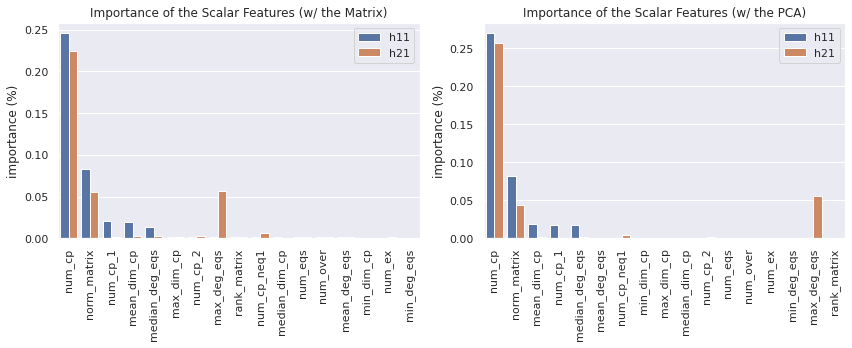

In [36]:
scalar_variables = ['num_cp', 'num_eqs',
                    'min_dim_cp', 'max_dim_cp',
                    'mean_dim_cp', 'median_dim_cp',
                    'num_cp_1', 'num_cp_2', 'num_cp_neq1',
                    'num_over', 'num_ex',
                    'min_deg_eqs', 'max_deg_eqs',
                    'mean_deg_eqs', 'median_deg_eqs',
                    'rank_matrix', 'norm_matrix'
                   ]

# save scalar importances
mat_scal_val = mat_imp.loc[scalar_variables]
mat_scal_val = mat_scal_val.sort_values(by='h11', ascending=False)
pca_scal_val = pca_imp.loc[scalar_variables]
pca_scal_val = pca_scal_val.sort_values(by='h11', ascending=False)

# plot the scalar features
fig, ax = subplots(1,2)

sns.barplot(data=pd.melt(mat_scal_val, id_vars='group'),
            x='group',
            y='value',
            hue='variable',
            ax=ax[0]
           )
ax[0].set(title='Importance of the Scalar Features (w/ the Matrix)',
          xlabel='',
          ylabel='importance (%)'
         )
ax[0].set_xticklabels(mat_scal_val['group'], rotation=90, ha='center')
ax[0].legend(title='')

sns.barplot(data=pd.melt(pca_scal_val, id_vars='group'),
            x='group',
            y='value',
            hue='variable',
            ax=ax[1]
           )
ax[1].set(title='Importance of the Scalar Features (w/ the PCA)',
          xlabel='',
          ylabel='importance (%)'
         )
ax[1].set_xticklabels(pca_scal_val['group'], rotation=90, ha='center')
ax[1].legend(title='')

plt.tight_layout()
plt.savefig(imgpath('scalar-features_orig.pdf'), dpi=150, format='pdf')

We can proceed with the same plots for the vector features:

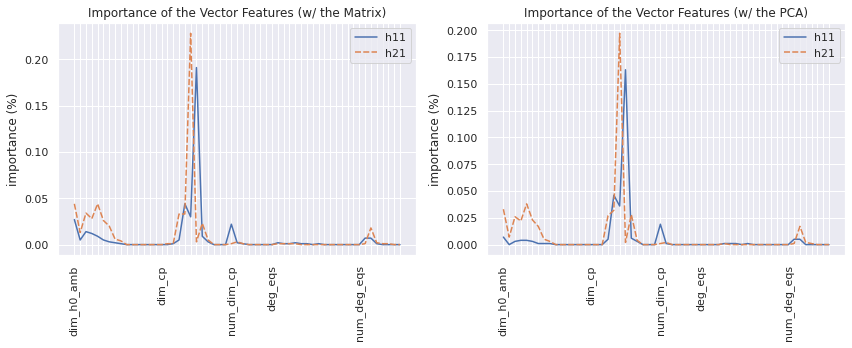

In [37]:
vector_features = ['dim_h0_amb',
                   'dim_cp', 'num_dim_cp',
                   'deg_eqs', 'num_deg_eqs'
                  ]

# save vector importances
mat_vec_val = mat_imp.loc[mat_imp['group'].isin(vector_features)].\
                      reset_index(drop=False)
pca_vec_val = pca_imp.loc[pca_imp['group'].isin(vector_features)].\
                      reset_index(drop=False)

# plot the vector features
fig, ax = subplots(1,2)

xticklabels = []
for f in vector_features:
    xticklabels.append(f)
    for n in range(np.prod(shape_dict[f]) - 1):
        xticklabels.append('')

sns.lineplot(data=mat_vec_val[['h11', 'h21']],
             ax=ax[0]
            )
ax[0].set(title='Importance of the Vector Features (w/ the Matrix)',
          xlabel='',
          ylabel='importance (%)',
          xticks=np.arange(mat_vec_val.shape[0])
         )
ax[0].set_xticklabels(xticklabels, rotation=90, ha='center')

sns.lineplot(data=pca_vec_val[['h11', 'h21']],
             ax=ax[1]
            )
ax[1].set(title='Importance of the Vector Features (w/ the PCA)',
          xlabel='',
          ylabel='importance (%)',
          xticks=np.arange(pca_vec_val.shape[0])
         )
ax[1].set_xticklabels(xticklabels, rotation=90, ha='center')

plt.tight_layout()
plt.savefig(imgpath('vector-features_orig.pdf'), dpi=150, format='pdf')

We then proceed with the matrix and PCA themselves:

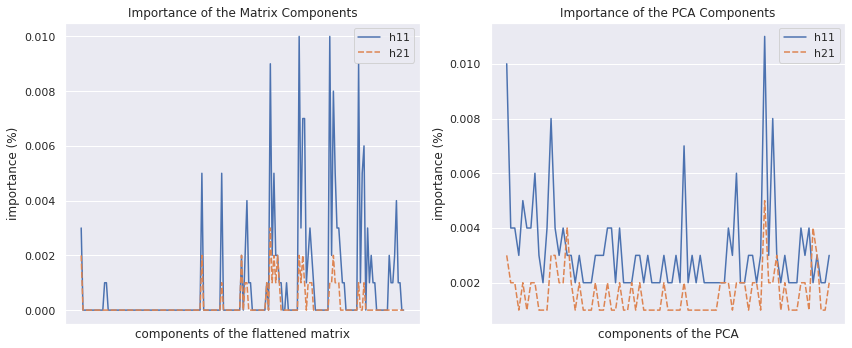

In [38]:
fig, ax = subplots(1,2)

sns.lineplot(data=mat_imp[mat_imp['group'] == 'matrix'][['h11', 'h21']],
             ax=ax[0]
            )
ax[0].set(title='Importance of the Matrix Components',
          xlabel='components of the flattened matrix',
          ylabel='importance (%)',
          xticks=np.arange(matrix_comp.shape[1], 10)
         )

sns.lineplot(data=pca_imp[pca_imp['group'] == 'pca'][['h11', 'h21']],
             ax=ax[1]
            )
ax[1].set(title='Importance of the PCA Components',
          xlabel='components of the PCA',
          ylabel='importance (%)',
          xticks=np.arange(matrix_comp_pca.shape[1], 10)
         )

plt.tight_layout()
plt.savefig(imgpath('tensor-features_orig.pdf'), dpi=150, format='pdf')

We then show the clustering importance for each cluster:

In [39]:
# define the tick labels
xticklabels = [str(n) + ' clusters' for n in cluster_range]

And plot the data:

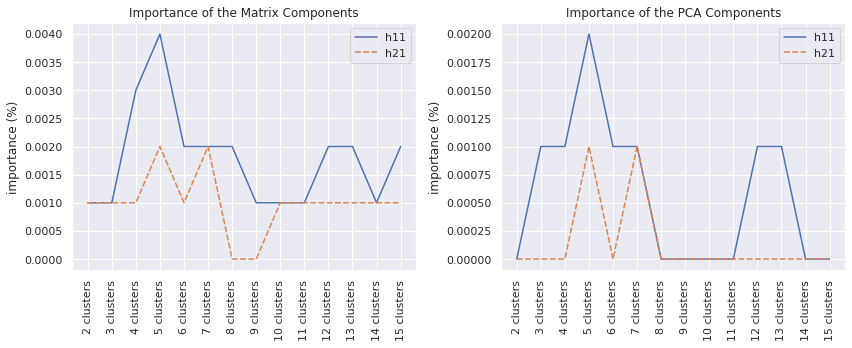

In [40]:
# plot the cluster features
fig, ax = subplots(1,2)

sns.lineplot(data=mat_imp[mat_imp['group'] == 'kmeans'][['h11', 'h21']],
             ax=ax[0]
            )
ax[0].set(title='Importance of the Matrix Components',
          xlabel='',
          ylabel='importance (%)'
         )
ax[0].set_xticklabels(xticklabels, rotation=90, ha='center')

sns.lineplot(data=pca_imp[pca_imp['group'] == 'kmeans'][['h11', 'h21']],
             ax=ax[1]
            )
ax[1].set(title='Importance of the PCA Components',
          xlabel='',
          ylabel='importance (%)'
         )
ax[1].set_xticklabels(xticklabels, rotation=90, ha='center')

plt.tight_layout()
plt.savefig(imgpath('cluster-features_orig.pdf'), dpi=150, format='pdf')

Finally we show the sum vector and tensor features:

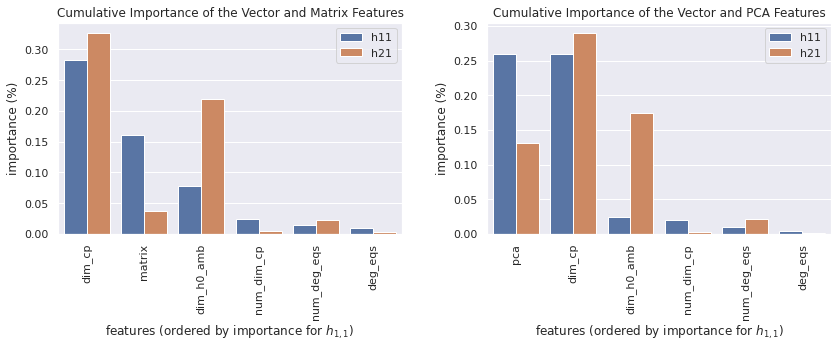

In [41]:
sum_mat_imp = mat_imp[(mat_imp['group'].isin(vector_features)) |
                      (mat_imp['group'] == 'matrix')
                     ].groupby('group').sum().sort_values(by='h11',
                                                          ascending=False
                                                         ).reset_index()
sum_pca_imp = pca_imp[(pca_imp['group'].isin(vector_features)) |
                      (pca_imp['group'] == 'pca')
                     ].groupby('group').sum().sort_values(by='h11',
                                                          ascending=False
                                                         ).reset_index()

fig, ax = subplots(1,2)

sns.barplot(data=pd.melt(sum_mat_imp, id_vars='group'),
            x='group',
            y='value',
            hue='variable',
            ax=ax[0]
           )
ax[0].set(title='Cumulative Importance of the Vector and Matrix Features',
          xlabel='features (ordered by importance for $h_{1,1}$)',
          ylabel='importance (%)'
         )
ax[0].set_xticklabels(sum_mat_imp['group'], rotation=90, ha='center')
ax[0].legend(title='')

sns.barplot(data=pd.melt(sum_pca_imp, id_vars='group'),
            x='group',
            y='value',
            hue='variable',
            ax=ax[1]
           )
ax[1].set(title='Cumulative Importance of the Vector and PCA Features',
          xlabel='features (ordered by importance for $h_{1,1}$)',
          ylabel='importance (%)'
         )
ax[1].set_xticklabels(sum_pca_imp['group'], rotation=90, ha='center')
ax[1].legend(title='')

plt.tight_layout()
plt.savefig(imgpath('vector-tensor-features_orig.pdf'), dpi=150, format='pdf')

As last step we show the cumulative importance of scalar, vector, cluster and tensor features:

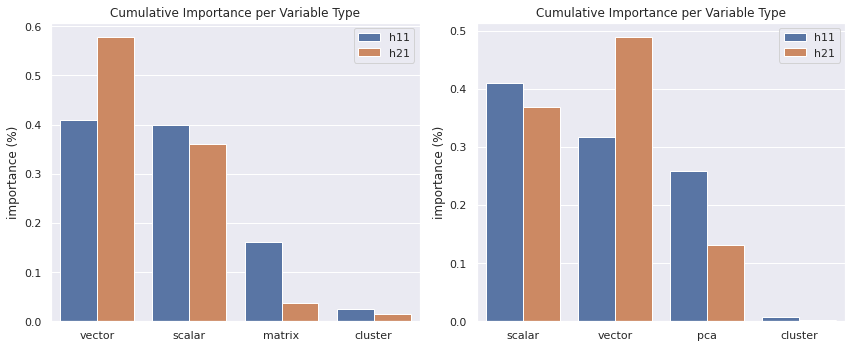

In [42]:
# add type label to be able to group the results
mat_imp.loc[mat_imp['group'].isin(scalar_variables), 'type'] = 'scalar'
mat_imp.loc[mat_imp['group'].isin(vector_features), 'type']  = 'vector'
mat_imp.loc[mat_imp['group'] == 'kmeans', 'type']            = 'cluster'
mat_imp.loc[mat_imp['group'] == 'matrix', 'type']            = 'matrix'

pca_imp.loc[pca_imp['group'].isin(scalar_variables), 'type'] = 'scalar'
pca_imp.loc[pca_imp['group'].isin(vector_features), 'type']  = 'vector'
pca_imp.loc[pca_imp['group'] == 'kmeans', 'type']            = 'cluster'
pca_imp.loc[pca_imp['group'] == 'pca', 'type']               = 'pca'

# compute the sum of the importance for each type
mat_full_imp = mat_imp.groupby('type').sum().sort_values('h11',
                                                         ascending=False).\
                                             reset_index()
pca_full_imp = pca_imp.groupby('type').sum().sort_values('h11',
                                                         ascending=False).\
                                             reset_index()

# plot the results
fig, ax = subplots(1,2)

sns.barplot(data=pd.melt(mat_full_imp, id_vars='type'),
            x='type',
            y='value',
            hue='variable',
            ax=ax[0]
           )
ax[0].set(title='Cumulative Importance per Variable Type',
          xlabel='',
          ylabel='importance (%)'
         )
ax[0].legend(title='')

sns.barplot(data=pd.melt(pca_full_imp, id_vars='type'),
            x='type',
            y='value',
            hue='variable',
            ax=ax[1]
           )
ax[1].set(title='Cumulative Importance per Variable Type',
          xlabel='',
          ylabel='importance (%)'
         )
ax[1].legend(title='')

plt.tight_layout()
plt.savefig(imgpath('cumulative-features_orig.pdf'), dpi=150, format='pdf')

In [43]:
matrix = df.filter(regex='^matrix.*')
matrix = matrix.values.reshape(-1,12,15,1)
#matrix = matrix / np.max(matrix)

In [44]:
labels = df[['h11', 'h21']].values

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(matrix,
                                                    labels,
                                                    test_size=0.1,
                                                    shuffle=True,
                                                    random_state=RAND
                                                   )
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=1.0/9.0,
                                                  shuffle=False
                                                 )

y_train_dict = {'h11_output': y_train[:,0],
                'h21_output': y_train[:,1]
               }
y_val_dict = {'h11_output': y_val[:,0],
              'h21_output': y_val[:,1]
             }
y_test_dict = {'h11_output': y_test[:,0],
               'h21_output': y_test[:,1]
              }

print('Training size: {:.3f} of the initial set.'.\
          format(X_train.shape[0] / df.shape[0]))
print('Validation size: {:.3f} of the initial set.'.\
          format(X_val.shape[0] / df.shape[0]))
print('Test size: {:.3f} of the initial set.'.\
          format(X_test.shape[0] / df.shape[0]))

Training size: 0.800 of the initial set.
Validation size: 0.100 of the initial set.
Test size: 0.100 of the initial set.


In [46]:
def inception(input_shape,
              learning_rate=0.01,
              conv_layers=[32],
              conv_padding='same',
              conv_alpha=0.0,
              fc_layers=[],
              fc_alpha=0.0,
              dropout=0.2,
              full_dropout=0.0,
              momentum=0.99,
              last_relu=True,
              out_name='output',
              l1_reg=0.0,
              l2_reg=0.0,
              rho=0.5
             ):
    
    # clear previous session
    tf.keras.backend.clear_session()
    
    # def. regulariser
    regulariser = tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
    
    # input layer
    I = tf.keras.Input(shape=input_shape, name='input')
    
    if conv_padding == 'same':
        x = I
    else:
        x = tf.keras.layers.ZeroPadding2D(padding=((0,3),(0,0)),
                                          data_format='channels_last'
                                         )(I)
        
    # build inceptions
    for n in range(len(conv_layers)):
        x1 = tf.keras.layers.Conv2D(filters=conv_layers[n],
                                    kernel_size=(x.shape[1],1),
                                    padding=conv_padding,
                                    kernel_regularizer=regulariser
                                   )(x)
        x1 = tf.keras.layers.LeakyReLU(alpha=conv_alpha)(x1)
        
        x2 = tf.keras.layers.Conv2D(filters=conv_layers[n],
                                    kernel_size=(1,x.shape[2]),
                                    padding=conv_padding,
                                    kernel_regularizer=regulariser
                                   )(x)
        x2 = tf.keras.layers.LeakyReLU(alpha=conv_alpha)(x2)
        
        x = tf.keras.layers.concatenate([x1, x2]) if conv_padding == 'same' \
            else tf.keras.layers.\
                    concatenate([x1, tf.einsum('bij...->bji...',x2)])
        
        if momentum > 0.0:
            x = tf.keras.layers.BatchNormalization(momentum=momentum)(x)
        if full_dropout > 0.0:
            x = tf.keras.layers.Dropout(rate=full_dropout)(x)
        
    # add dropout
    if dropout > 0.0 and full_dropout <= 0.0:
        x = tf.keras.layers.Dropout(rate=dropout)(x)
        
    # flatten the output
    x = tf.keras.layers.Flatten()(x)
    
    # build FC network
    for n in range(len(fc_layers)):
        x = tf.keras.layers.Dense(units=fc_layers[n],
                                  kernel_regularizer=regulariser
                                 )(x)
        x = tf.keras.layers.LeakyReLU(alpha=fc_alpha)(x)
        
        if momentum > 0.0:
            x = tf.keras.layers.BatchNormalization(momentum=momentum)(x)
        if full_dropout > 0.0:
            x = tf.keras.layers.Dropout(rate=full_dropout)(x)
        
    # build output
    if last_relu:
        h11_out = tf.keras.layers.Dense(units=1,
                                        kernel_regularizer=regulariser,
                                        activation='relu',
                                        name='h11_output'
                                       )(x)
        h21_out = tf.keras.layers.Dense(units=1,
                                        kernel_regularizer=regulariser,
                                        activation='relu',
                                        name='h21_output'
                                       )(x)
    else:
        h11_out = tf.keras.layers.Dense(units=1,
                                        kernel_regularizer=regulariser,
                                       )(x)
        h11_out = tf.keras.layers.LeakyReLU(alpha=fc_alpha,
                                            name='h11_output'
                                           )(x)
        h21_out = tf.keras.layers.Dense(units=1,
                                        kernel_regularizer=regulariser,
                                       )(x)
        h21_out = tf.keras.layers.LeakyReLU(alpha=fc_alpha,
                                            name='h21_output'
                                           )(x)
        
        
    # collect output layers
    output_layers = {}
    output_layers['h11_output'] = h11_out
    output_layers['h21_output'] = h21_out
    
    # collect weights
    loss_weights = {'h11_output': rho, 'h21_output': 1 - rho}
    
    # build the model
    model = tf.keras.Model(inputs=I, outputs=output_layers)
    model.compile(optimizer=tf.keras.optimizers.\
                               Adam(learning_rate=learning_rate),
                  loss='mse',
                  loss_weights=loss_weights,
                  metrics=['mse', 'mae']
                 )
    
    return model

In [47]:
model = inception((12,15,1),
                  learning_rate=0.001,
                  l1_reg=1.0e-5,
                  l2_reg=1.0e-5,
                  momentum=0.99,
                  conv_alpha=0.0,
                  fc_alpha=0.0,
                  dropout=0.3,
                  conv_layers=[96, 64, 32],
                  fc_layers=[],
                  conv_padding='same',
                  rho=0.5
                 )

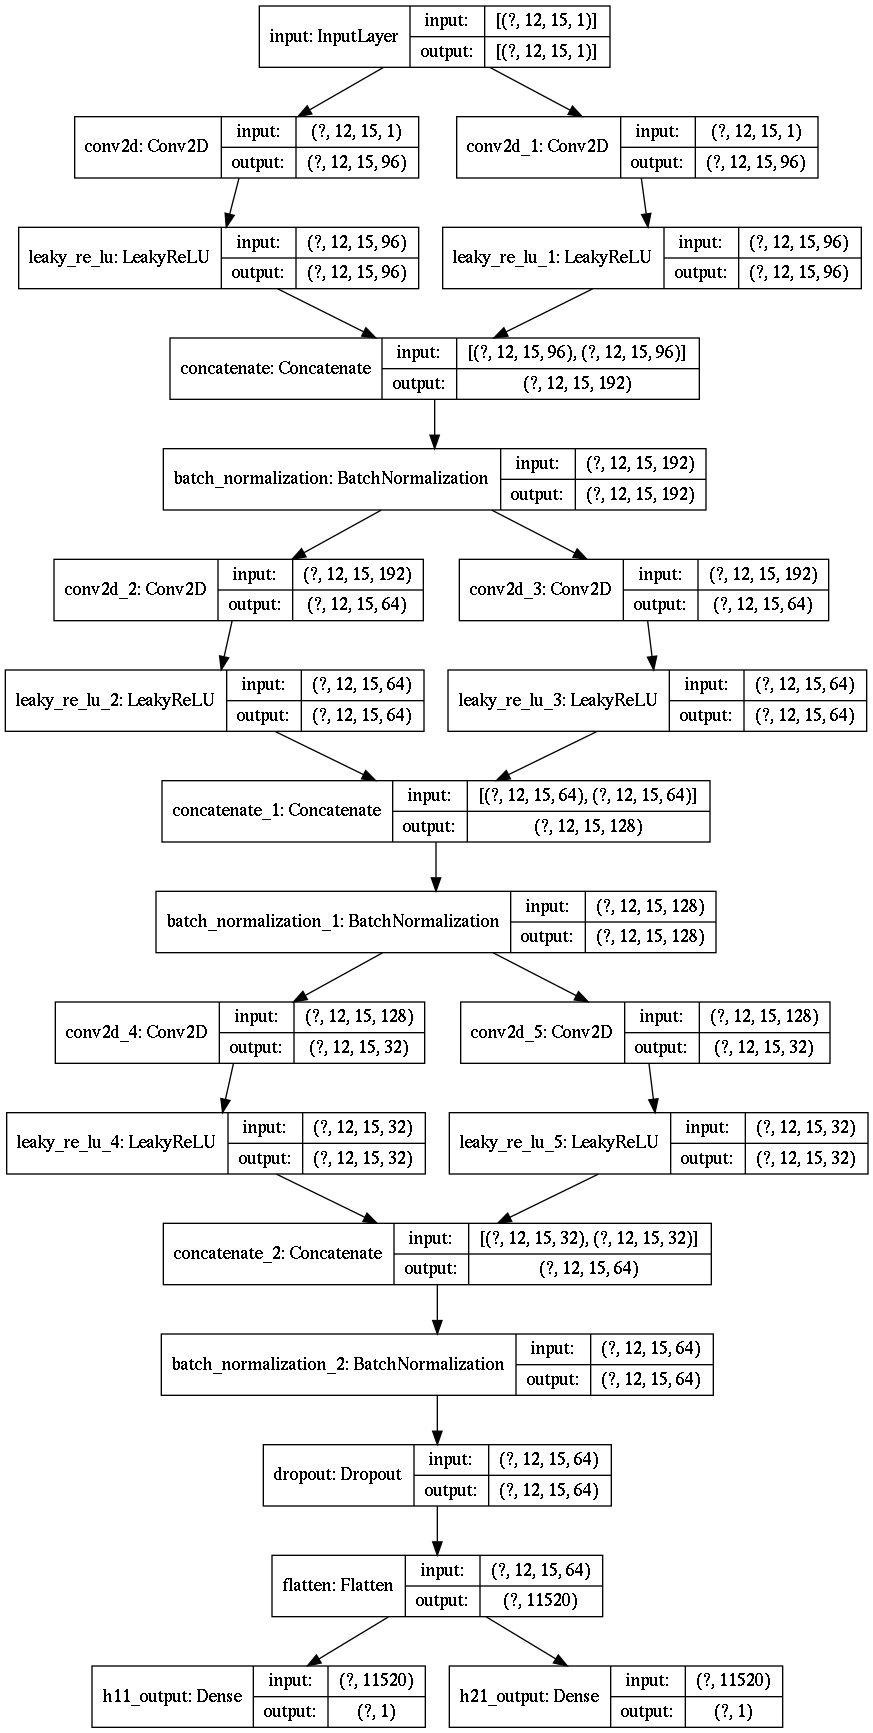

In [48]:
from IPython.display import Image

model_dot = tf.keras.utils.model_to_dot(model, show_shapes=True)
Image(model_dot.create_png())

In [49]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 12, 15, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 12, 15, 96)   1248        input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 12, 15, 96)   1536        input[0][0]                      
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 12, 15, 96)   0           conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(modpath('inception.h5'),
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True
                                               ),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.3,
                                                  patience=75,
                                                  verbose=1
                                                 ),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              min_delta=1.0e-4,
                                              patience=250,
                                              restore_best_weights=True,
                                              verbose=1
                                             )
            ]

model_hst = model.fit(x=X_train,
                      y=y_train_dict,
                      batch_size=32,
                      epochs=2000,
                      validation_data=(X_val, y_val_dict),
                      callbacks=callbacks
                     )

Epoch 1/2000
197/197 [==============================] - ETA: 0s - loss: 20.6926 - h11_output_loss: 3.7985 - h21_output_loss: 37.3715 - h11_output_mse: 3.7985 - h11_output_mae: 1.4857 - h21_output_mse: 37.3715 - h21_output_mae: 4.2479
Epoch 00001: val_loss improved from inf to 90.07061, saving model to ./mod/inception.h5
197/197 [==============================] - 21s 107ms/step - loss: 20.6926 - h11_output_loss: 3.7985 - h21_output_loss: 37.3715 - h11_output_mse: 3.7985 - h11_output_mae: 1.4857 - h21_output_mse: 37.3715 - h21_output_mae: 4.2479 - val_loss: 90.0706 - val_h11_output_loss: 61.7847 - val_h21_output_loss: 118.1397 - val_h11_output_mse: 61.7847 - val_h11_output_mae: 7.5478 - val_h21_output_mse: 118.1397 - val_h21_output_mae: 8.0675 - lr: 0.0010
Epoch 2/2000
197/197 [==============================] - ETA: 0s - loss: 11.8321 - h11_output_loss: 2.3062 - h21_output_loss: 21.1394 - h11_output_mse: 2.3062 - h11_output_mae: 1.1846 - h21_output_mse: 21.1394 - h21_output_mae: 3.2648
E

In [ ]:
# compute predictions
predictions = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, \
                            mean_squared_error, \
                            mean_absolute_error

# compute metrics
h11_pred = predictions['h11_output'].reshape(-1,)
h21_pred = predictions['h21_output'].reshape(-1,)

h11_true = y_test_dict['h11_output'].reshape(-1,)
h21_true = y_test_dict['h21_output'].reshape(-1,)

print('h11 ACC: {:.3f}'.format(accuracy_score(h11_true, np.rint(h11_pred))))
print('h11 MSE: {:.3f}'.format(mean_squared_error(h11_true, h11_pred)))
print('h11 MAE: {:.3f}'.format(mean_absolute_error(h11_true, h11_pred)))
print('\n')
print('h21 ACC: {:.3f}'.format(accuracy_score(h21_true, np.rint(h21_pred))))
print('h21 MSE: {:.3f}'.format(mean_squared_error(h21_true, h21_pred)))
print('h21 MAE: {:.3f}'.format(mean_absolute_error(h21_true, h21_pred)))

In [ ]:
# print histogram of residuals
h11_res = h11_true - h11_pred
h21_res = h21_true - h21_pred

fig, ax = subplots(1,2)

sns.distplot(h11_res,
             kde=False,
             ax=ax[0]
            )
ax[0].set(title='Residuals for $h_{1,1}$',
          xlabel='residuals',
          ylabel='#'
         )

sns.distplot(h21_res,
             kde=False,
             ax=ax[1]
            )
ax[1].set(title='Residuals for $h_{2,1}$',
          xlabel='residuals',
          ylabel='#'
         )

plt.tight_layout()
plt.savefig(path.join('/home/riccardo', 'histogram.pdf'), format='pdf')

In [ ]:
# residual plot

fig, ax = subplots(1,2)

sns.scatterplot(x=h11_pred,
                y=h11_res,
                ax=ax[0]
               )
ax[0].set(title='Residual Plot for $h_{1,1}$',
          xlabel='predicted $h_{1,1}$',
          ylabel='residuals'
         )

sns.scatterplot(x=h21_pred,
                y=h21_res,
                ax=ax[1]
               )
ax[1].set(title='Residual Plot for $h_{2,1}$',
          xlabel='predicted $h_{2,1}$',
          ylabel='residuals'
         )

plt.tight_layout()
plt.savefig(path.join('/home/riccardo', 'residual_plot.pdf'), format='pdf')